In [4]:
from exp.utils import *
from exp.models import *
from exp.losses import *
from fastai.vision.all import *

In [5]:
p_train_valid = get_data_path()/"train_valid_images"
device = get_device()

Using the GPU!


In [6]:
labels = sorted(get_labels())
labels = ["Cardiomegaly", "Mass", "Pneumonia"]

In [7]:
def get_dfs(label):
    train_df, valid_df, test_df = get_dataframes(include_labels=get_labels(), 
                                                 small=False)
    #print(train_df.shape, valid_df.shape, test_df.shape)
    train_df = get_binary_df(label, train_df)
    valid_df = get_binary_df(label, valid_df)
    test_df  = get_binary_df(label, test_df)

    complete_df = pd.concat([train_df, valid_df, test_df])
    complete_df = complete_df.drop(columns=["Follow-up #", "Patient ID", "Patient Age", "Patient Gender", 
                       "View Position", "OriginalImage[Width", "Height]", 
                       "OriginalImagePixelSpacing[x", "y]", "No Finding"])
    return train_df, valid_df, complete_df

def get_label_func(label):
    return partial(partial_label_func, label)

def partial_label_func(label, fname):
    lbl = complete_df[complete_df["Image Index"] == fname.name][label].values[0]
    return "Pos" if lbl > 0 else "Neg"

def splitter_func(fn):
    return fn.parent.stem == "valid_images" 

def get_weights(label):
    train_label = train_df[[label]].values
    neg_weights, pos_weights = compute_class_freqs(train_label)
    neg_weights, pos_weights = torch.Tensor(neg_weights), torch.Tensor(pos_weights)
    weights = torch.Tensor([neg_weights, pos_weights]).to(device)
    return weights

def get_dls(bs, image_size, path=p_train_valid):
    batch_tfms = [Brightness(), 
                  Contrast(),
                  RandomErasing(p=.25, max_count=2)] 
    
    dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y     = label_func,
                       splitter  = FuncSplitter(splitter_func),
                       item_tfms = [Resize(image_size, 
                                          method="squish", 
                                          pad_mode="zeros")],
                       batch_tfms = batch_tfms)
    return dblock.dataloaders(path, bs=bs)

def namify(label):
    return "".join(label.split(" ")).lower()

Training Atelectasis...


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.394874,0.405525,0.905865,0.606651,02:45
1,0.397013,0.397673,0.905865,0.620369,02:44
2,0.398359,0.404857,0.905865,0.589027,02:44
3,0.389351,0.395112,0.905865,0.664489,02:44
4,0.390705,0.418264,0.905865,0.625181,02:44
5,0.387098,0.384627,0.905865,0.713776,02:45
6,0.388477,0.380486,0.905865,0.731313,02:45
7,0.387597,0.375266,0.905865,0.746802,02:44
8,0.380845,0.375584,0.905808,0.753176,02:45
9,0.382639,0.377468,0.905865,0.753044,02:45


Better model found at epoch 0 with valid_loss value: 0.4055253863334656.


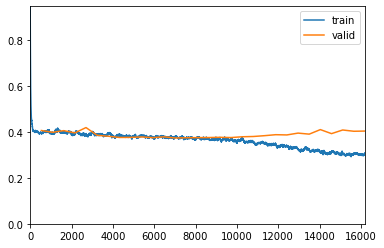

Better model found at epoch 1 with valid_loss value: 0.3976730704307556.
Better model found at epoch 3 with valid_loss value: 0.3951123058795929.
Better model found at epoch 5 with valid_loss value: 0.38462668657302856.
Better model found at epoch 6 with valid_loss value: 0.38048553466796875.
Better model found at epoch 7 with valid_loss value: 0.3752659261226654.
Better model found at epoch 10 with valid_loss value: 0.37444812059402466.
Better model found at epoch 12 with valid_loss value: 0.37296760082244873.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.391015,0.378015,0.905865,0.734866,03:11
1,0.385676,0.374250,0.905865,0.756895,03:10
2,0.378538,0.375040,0.905865,0.751208,03:11
3,0.382551,0.373630,0.905923,0.761717,03:11
4,0.387456,0.376889,0.905981,0.753488,03:11
5,0.370008,0.386625,0.905865,0.743148,03:12
6,0.377815,0.374768,0.904941,0.756618,03:11
7,0.375715,0.373612,0.906039,0.759834,03:11
8,0.379497,0.376451,0.905923,0.745286,03:11
9,0.366093,0.375740,0.906039,0.762869,03:11


Better model found at epoch 0 with valid_loss value: 0.37801462411880493.


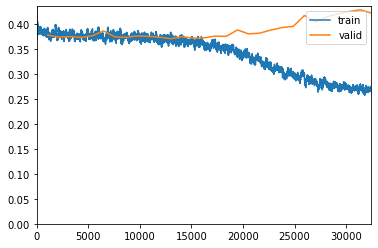

Better model found at epoch 1 with valid_loss value: 0.3742503225803375.
Better model found at epoch 3 with valid_loss value: 0.37363049387931824.
Better model found at epoch 7 with valid_loss value: 0.37361249327659607.
Better model found at epoch 11 with valid_loss value: 0.37097373604774475.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.371655,0.372149,0.906154,0.763737,07:52
1,0.375807,0.369735,0.906039,0.774593,07:52
2,0.376607,0.374908,0.905808,0.778091,07:53
3,0.371743,0.372387,0.904883,0.771682,07:52
4,0.370318,0.373841,0.901820,0.769661,07:53
5,0.373425,0.373230,0.904478,0.782622,07:53
6,0.367450,0.371098,0.905403,0.771479,07:53
7,0.359481,0.375399,0.906154,0.768610,07:52
8,0.370466,0.369744,0.904536,0.780640,07:52
9,0.375524,0.388164,0.891130,0.779579,07:52


Better model found at epoch 0 with valid_loss value: 0.3721485137939453.


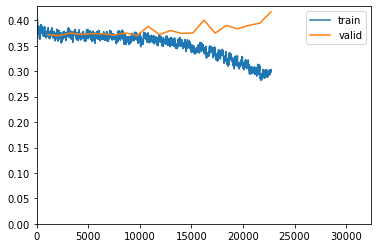

Better model found at epoch 1 with valid_loss value: 0.36973506212234497.
No improvement since epoch 1: early stopping
Training Cardiomegaly...


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.249777,0.246976,0.982722,0.616523,02:45
1,0.252926,0.276423,0.982722,0.542854,02:46
2,0.254142,0.241645,0.982722,0.646791,02:46
3,0.247906,0.242109,0.982722,0.709691,02:46
4,0.249441,0.241810,0.982722,0.689980,02:46
5,0.248057,0.238524,0.982722,0.772409,02:46
6,0.244717,0.239649,0.982953,0.852378,02:47
7,0.247866,0.236907,0.982722,0.861956,02:46
8,0.246408,0.235680,0.982837,0.876347,02:46
9,0.240359,0.234470,0.982953,0.889410,02:46


Better model found at epoch 0 with valid_loss value: 0.2469756156206131.


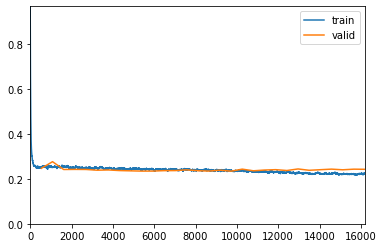

Better model found at epoch 2 with valid_loss value: 0.24164524674415588.
Better model found at epoch 5 with valid_loss value: 0.23852357268333435.
Better model found at epoch 7 with valid_loss value: 0.23690715432167053.
Better model found at epoch 8 with valid_loss value: 0.23567993938922882.
Better model found at epoch 9 with valid_loss value: 0.23447009921073914.
Better model found at epoch 17 with valid_loss value: 0.23420672118663788.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.247489,0.240743,0.982722,0.773178,03:10
1,0.240988,0.236147,0.982953,0.830961,03:11
2,0.245417,0.234301,0.983126,0.892401,03:11
3,0.243098,0.236912,0.983126,0.873479,03:11
4,0.244483,0.235416,0.983068,0.862225,03:11
5,0.243631,0.234259,0.983357,0.898578,03:11
6,0.247588,0.241594,0.981797,0.797773,03:11
7,0.242479,0.234590,0.982953,0.867398,03:12
8,0.236968,0.240933,0.981219,0.876521,03:11
9,0.246577,0.234770,0.982837,0.885179,03:11


Better model found at epoch 0 with valid_loss value: 0.24074271321296692.


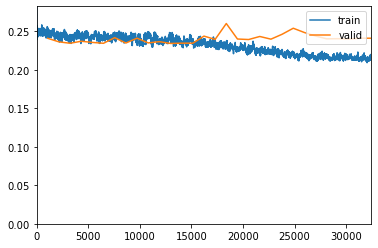

Better model found at epoch 1 with valid_loss value: 0.23614729940891266.
Better model found at epoch 2 with valid_loss value: 0.2343011051416397.
Better model found at epoch 5 with valid_loss value: 0.23425856232643127.
Better model found at epoch 11 with valid_loss value: 0.23407010734081268.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.247306,0.237609,0.982722,0.808542,07:50
1,0.239407,0.233909,0.983184,0.887936,07:53
2,0.236880,0.234749,0.983184,0.854268,07:53
3,0.239357,0.234511,0.982953,0.900164,07:52
4,0.240613,0.235293,0.982953,0.844370,07:53
5,0.236772,0.235268,0.983011,0.864027,07:53
6,0.240154,0.234508,0.983300,0.890298,07:52
7,0.243185,0.233303,0.983357,0.896144,07:53
8,0.240619,0.235099,0.983011,0.881759,07:52
9,0.244280,0.241889,0.981450,0.870784,07:53


Better model found at epoch 0 with valid_loss value: 0.23760868608951569.


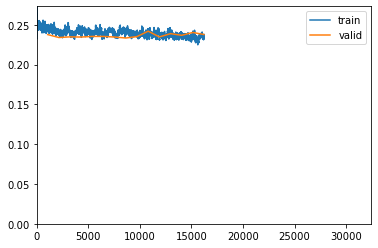

Better model found at epoch 1 with valid_loss value: 0.23390914499759674.
Better model found at epoch 7 with valid_loss value: 0.23330308496952057.


IndexError: list index out of range

In [8]:
for label in labels:
    print()
    # Setup
    train_df, valid_df, complete_df = get_dfs(label)
    label_func = get_label_func(label)
    #weights = get_weights(label)
    model_name = f"xresnet50_finetuned_{namify(label)}_v1"
    
    # Callbacks
    sched = {'lr': SchedExp(3e-3, 1e-9)}
    callbacks = [
        ParamScheduler(sched),
        EarlyStoppingCallback(monitor="valid_loss",
                              patience=20),
        SaveModelCallback(monitor="valid_loss", 
                          fname=model_name, 
                          with_opt=True),
        ShowGraphCallback(), 
        MixUp()
    ]
    
    # First increment
    print(f"Training {label} @ size 64...")
    dls = get_dls(bs=128, image_size=64)
    model = xresnet50(n_out=dls.c)
    learn = Learner(dls, 
                    model, 
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy, RocAucBinary()],
                    cbs=callbacks)
    learn.fit_one_cycle(30)
    
    # Second increment
    print(f"Training {label} @ size 128...")
    learn.load(Path().cwd()/"models"/model_name)
    learn.dls = get_dls(bs=64, image_size=128)
    learn.fit_one_cycle(30)
    
    # Final increment
    print(f"Training {label} @ size 224...")
    learn.load(Path().cwd()/"models"/model_name)
    learn.dls = get_dls(bs=64, image_size=224)
    learn.fit_one_cycle(30)